# 02 - EDA   

## Setup

In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown

sns.set(style="darkgrid")
pd.set_option('display.max_columns', None)  

import sys, os, yaml

DATASET = "Tic-Tac-Toe"
COLAB = 'google.colab' in sys.modules

DEBUG = False
SEED = 666

In [281]:
COLAB = 'google.colab' in sys.modules

if COLAB:
  from google.colab import drive
  if not os.path.isdir("/content/gdrive"):
    drive.mount("/content/gdrive")
    d = "/content/gdrive/MyDrive/datasets"
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d)
  ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"
  if not os.path.isdir(ROOT): os.makedirs(ROOT)
else:
  ROOT = "./"

def makedirs(d):
  if COLAB:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d)
  else:
    if not os.path.isdir(ROOT+d): os.makedirs(ROOT+d, mode=0o777, exist_ok=True)

for d in ['orig','data','output']: makedirs(d)

## Load Dataset

In [282]:
df = pd.read_pickle(f"{ROOT}/data/data.pkl")
print(df.shape)
df.head()

(958, 10)


,Top-left-square,Top-middle-square,Top-right-square,Middle-left-square,Middle-middle-square,Middle-right-square,Bottom-left-square,Bottom-middle-square,Bottom-right-square,Score
0,1,1,1,1,-1,-1,1,-1,-1,1
1,1,1,1,1,-1,-1,-1,1,-1,1
2,1,1,1,1,-1,-1,-1,-1,1,1
3,1,1,1,1,-1,-1,-1,0,0,1
4,1,1,1,1,-1,-1,0,-1,0,1


# EDA 

In [283]:
target = "Score"
cat_features = [c for c in df.select_dtypes("category").columns if c!= target]

In [284]:
df[target].value_counts(normalize=True)

Score
1     0.653445
-1    0.346555
Name: proportion, dtype: float64

In [285]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Top-left-square       958 non-null    category
 1   Top-middle-square     958 non-null    category
 2   Top-right-square      958 non-null    category
 3   Middle-left-square    958 non-null    category
 4   Middle-middle-square  958 non-null    category
 5   Middle-right-square   958 non-null    category
 6   Bottom-left-square    958 non-null    category
 7   Bottom-middle-square  958 non-null    category
 8   Bottom-right-square   958 non-null    category
 9   Score                 958 non-null    category
dtypes: category(10)
memory usage: 9.7 KB


checando se todas as linhas do dataset respeitam a regra do # (verificando se há incosistência nos dados)

- O número de `X` num dado Estado seria um a mais ou igual ao número de `O` colocado no tabuleiro.

como X = 1 e O = -1, a soma nos da a diferença dos módulos.

In [286]:
row_sums = df[cat_features].astype("int").sum(axis=1)
result = (row_sums < 0) | (row_sums > 1)
result.sum()

0

Sem dados inconsistentes. Dataset já está limpo

procurando por simetrias

In [287]:
# Pattern to search
pattern = [1,-1,1,-1,-1,-1,1,1,0]

# Reshape the pattern to a 3x3 matrix for comparison
pattern_matrix = np.array(pattern).reshape(3, 3)

# Iterate through the DataFrame and check for symmetry positions
for index, row in df.iterrows():
    # Extract the values from the DataFrame row
    row_values = row[:-1].values
    
    # Reshape the row values to a 3x3 matrix for comparison
    row_matrix = np.array(row_values).reshape(3, 3)
    
    # Check if the row matrix is a symmetry position of the pattern
    if np.array_equal(row_matrix, pattern_matrix) or np.array_equal(np.fliplr(row_matrix), pattern_matrix):
        print(f"Symmetry position found at index {index}")


Symmetry position found at index 680
Symmetry position found at index 682


- possui simetrias

Verificando a diversidades de posições, se há jogos inacabados ou apenas jogos com resultado final

In [288]:
def is_winnerrr(board, player):
    # Check rows, columns, and diagonals for a win
    for i in range(3):
        if all(board[i][j] == player for j in range(3)) or all(board[j][i] == player for j in range(3)):
            return True
    if all(board[i][i] == player for i in range(3)) or all(board[i][2 - i] == player for i in range(3)):
        return True
    return False

def is_drawww(board):
    # Check if the board is full and no one has won
    return all(board[i][j] != 0 for i in range(3) for j in range(3)) and not is_winnerrr(board, 1) and not is_winnerrr(board, -1)

def evaluate(board):
    if is_winnerrr(board, 1):
        return 1  # 'X' wins
    elif is_winnerrr(board, -1):
        return -1  # 'O' wins
    elif is_drawww(board):
        return 0  # It's a draw
    else:
        return 666
    
# Function to convert DataFrame row to a 3x3 matrix
def row_to_matrix(row):
    return np.array(row[:].values).reshape(3, 3)

def check_end_games(df):
    not_finished = []
    for index, row in df[cat_features].iterrows():
        board_matrix = row_to_matrix(row)
        position_score = evaluate(board_matrix)
        if position_score > 1:
            not_finished.append(index)
    
    return len(not_finished)

In [289]:
check_end_games(df)

0

não há jogos inacabados

#### Saving

Salvando o dataframe como Pickle, pois é uma maneira serializada de armazenar um dataframe Pandas. Basicamente, você está anotando a representação exata do dataframe no disco. 
- mais rápido
- menos pesado
- não possibilita "leitura humana", e por isso, como mais adiante fizemos uma análise mais aprofundada nos dados, salvamos também como .csv para leitura. Mas não haveria necessidade.

In [290]:
df[cat_features] = df[cat_features].astype("category")

In [291]:
df.to_pickle(f"{ROOT}/data/data.pkl")
df.to_csv(f"{ROOT}/data/data.csv")

In [292]:
df2 = df.copy()

# Nossa análise e abordagem sobre o dataset

## Comments

[Pedro] Quando vi pela primeira vez o dataset me estranhou um pouco o tamanho. Após terminar o projeto e percerber que na verdade "todas as possibilidades", na verdade não eram todas, pois algumas posições não estavam consideradas no dataset.

Dado isso, fui pesquisar de onde viria um valor tão pequeno, então encontrei uma pesquisa sobre quantas posições existem no Jogo da Velha http://www.se16.info/hgb/tictactoe.htm que me levou a https://www.egr.msu.edu/~kdeb/papers/k2007002.pdf . Então pude entender que estavam considerando a simetria das posições e "enxutando" o dataset... 

E com uma segunda análise ao Dataset proposto no projeto, percebi que não estavam considerando posições "early stage", e sim estados com pelo menos 5 jogadas já feitas.

dado isso resolvi fazer o treino com um dataset menos "enxuto".

Segui os seguintes passos:

- me preocupei em gerar as posições como comentado em http://www.se16.info/hgb/tictactoe.htm 

- apliquei as regras de existência (a) e (b) comentadas em https://www.egr.msu.edu/~kdeb/papers/k2007002.pdf

- Para o Score, avaliei cada posição com o algoritmo MinMax (https://www.geeksforgeeks.org/finding-optimal-move-in-tic-tac-toe-using-minimax-algorithm-in-game-theory/), que avalia a posição considerando jogadas ótimas de X e O até o final.

o resultado foi um dataset maior e com mais posições de inicio de jogo e quase nenhum final, tendo em vista que MinMax já enxerga a vitória ou derrota garantidas algumas jogadas antes.
Para contornar esse problema, que iria impactar negativamente no treino do nosso classificador, uni o útil ao agradável, concatenei os dois datasets e apaguei duplicatas.

In [293]:
# [Partes do código abaixo foi gerado com ChatGPT]
"""
def is_winner(board, player):
    # Check rows, columns, and diagonals for a win
    for i in range(3):
        if all(board[i][j] == player for j in range(3)) or all(board[j][i] == player for j in range(3)):
            return True
    if all(board[i][i] == player for i in range(3)) or all(board[i][2 - i] == player for i in range(3)):
        return True
    return False

def is_draw(board):
    # Check if the board is full and no one has won
    return all(board[i][j] != 'b' for i in range(3) for j in range(3)) and not is_winner(board, 'X') and not is_winner(board, 'O')

def evaluate_position(board, player):
    if is_winner(board, 'X'):
        return 1  # 'X' wins
    elif is_winner(board, 'O'):
        return -1  # 'O' wins
    elif is_draw(board):
        return 0  # It's a draw

    if player == 'X':
        max_eval = float('-inf')
        for i in range(3):
            for j in range(3):
                if board[i][j] == 'b':
                    board[i][j] = 'X'
                    eval = evaluate_position(board, 'O')
                    board[i][j] = 'b'  # Undo the move
                    max_eval = max(max_eval, eval)
        return max_eval
    else:
        min_eval = float('inf')
        for i in range(3):
            for j in range(3):
                if board[i][j] == 'b':
                    board[i][j] = 'O'
                    eval = evaluate_position(board, 'X')
                    board[i][j] = 'b'  # Undo the move
                    min_eval = min(min_eval, eval)
        return min_eval

def generate_positions():
    board = [['b'] * 3 for _ in range(3)]
    positions = set()

    def generate_moves(player, moves):
        nonlocal positions
        flattened_position = tuple(item for sublist in board for item in sublist)

        # Check rule (a): The number of 'X' in any given state would be either one more than or equal to the number of 'O' placed on the board.
        count_x = sum(row.count('X') for row in board)
        count_o = sum(row.count('O') for row in board)
        if not (count_x >= count_o):
            return  # Skip this position if rule (a) is violated

        # Check rule (b): Either player would not move if the other has won.
        if (player == 'X' and is_winner(board, 'O')) or (player == 'O' and is_winner(board, 'X')):
            return  # Skip this position if rule (b) is violated

        score = evaluate_position(board, player)
        positions.add(flattened_position + (score,))

        if moves < 9:
            for i in range(3):
                for j in range(3):
                    if board[i][j] == 'b':
                        board[i][j] = player
                        generate_moves('O' if player == 'X' else 'X', moves + 1)
                        board[i][j] = 'b'

    # Adjust the depth parameter based on your desired exploration depth
    generate_moves('X', 0)

    
    # Convert set of tuples to a list and sort for consistency
    positions = list(positions)
    
    return positions


all_positions = generate_positions()

# Create a DataFrame with flattened positions and a "Score" column
df = pd.DataFrame(all_positions, columns=[
    'Top-left-square', 'Top-middle-square', 'Top-right-square',
    'Middle-left-square', 'Middle-middle-square', 'Middle-right-square',
    'Bottom-left-square', 'Bottom-middle-square', 'Bottom-right-square',
    'Score'
])
df["Score"] = df.Score == 1
print(df.shape)
df.head()
"""

df = pd.read_pickle(f"{ROOT}/data/data_2.pkl")
print(df.shape)
df.head()

(4536, 10)


,Top-left-square,Top-middle-square,Top-right-square,Middle-left-square,Middle-middle-square,Middle-right-square,Bottom-left-square,Bottom-middle-square,Bottom-right-square,Score
0,1,-1,1,1,0,0,0,0,-1,-1
1,1,1,-1,0,-1,-1,1,-1,1,1
2,0,1,0,0,0,0,1,-1,0,-1
3,1,0,-1,1,0,0,0,0,0,1
4,-1,1,-1,-1,1,-1,1,0,1,1


In [294]:
for c in df.columns:
    if df[c].dtype == 'object':
        df[c] = df[c].map({'X':1, 'O':-1,'b':0})
        df[c] = df[c].astype("category")
    if df[c].dtype == 'bool':
        df[c] = df[c].map({True: 1, False: -1})
        df[c] = df[c].astype("category")

print(df.shape)
df.head(2)

(4536, 10)


,Top-left-square,Top-middle-square,Top-right-square,Middle-left-square,Middle-middle-square,Middle-right-square,Bottom-left-square,Bottom-middle-square,Bottom-right-square,Score
0,1,-1,1,1,0,0,0,0,-1,-1
1,1,1,-1,0,-1,-1,1,-1,1,1


In [295]:
#df.to_csv(f"{ROOT}/data/data_2.csv")
#df.to_pickle(f"{ROOT}/data/data_2.pkl")

In [296]:
target = "Score"
cat_features = [c for c in df.select_dtypes("category").columns if c!= target]

In [297]:
df[cat_features] = df[cat_features].astype("int")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4536 entries, 0 to 4535
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Top-left-square       4536 non-null   int32   
 1   Top-middle-square     4536 non-null   int32   
 2   Top-right-square      4536 non-null   int32   
 3   Middle-left-square    4536 non-null   int32   
 4   Middle-middle-square  4536 non-null   int32   
 5   Middle-right-square   4536 non-null   int32   
 6   Bottom-left-square    4536 non-null   int32   
 7   Bottom-middle-square  4536 non-null   int32   
 8   Bottom-right-square   4536 non-null   int32   
 9   Score                 4536 non-null   category
dtypes: category(1), int32(9)
memory usage: 164.0 KB


In [298]:
df2[cat_features] = df2[cat_features].astype("int")
df2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Top-left-square       958 non-null    int32   
 1   Top-middle-square     958 non-null    int32   
 2   Top-right-square      958 non-null    int32   
 3   Middle-left-square    958 non-null    int32   
 4   Middle-middle-square  958 non-null    int32   
 5   Middle-right-square   958 non-null    int32   
 6   Bottom-left-square    958 non-null    int32   
 7   Bottom-middle-square  958 non-null    int32   
 8   Bottom-right-square   958 non-null    int32   
 9   Score                 958 non-null    category
dtypes: category(1), int32(9)
memory usage: 34.9 KB


#### X´s and O´s

Checando a ocorrência de jogadas nas posições de cada dataset

count    4536.000000
mean        5.435847
std         1.338871
min         0.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
dtype: float64


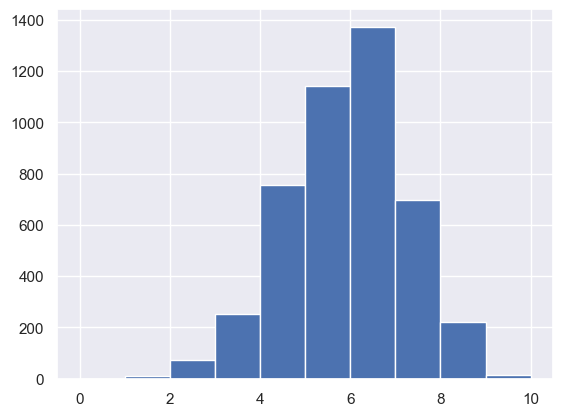

In [299]:
data = (df[cat_features]!=0).sum(axis=1)
print(data.describe())
plt.hist(data, bins=range(11))
plt.show()

count    958.000000
mean       6.933194
std        1.073926
min        5.000000
25%        6.000000
50%        7.000000
75%        8.000000
max        9.000000
dtype: float64


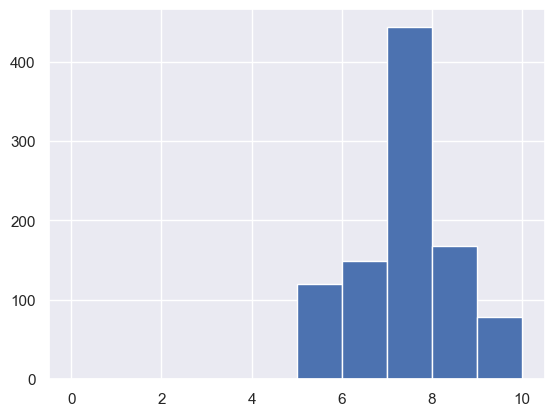

In [300]:
data = (df2[cat_features]!=0).sum(axis=1)
print(data.describe())
plt.hist(data, bins=range(11))
plt.show()

#### Blank

Mostrando a ocorrência de posições vazias. (equivalente ao anterior)

count    4536.000000
mean        3.564153
std         1.338871
min         0.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         9.000000
dtype: float64


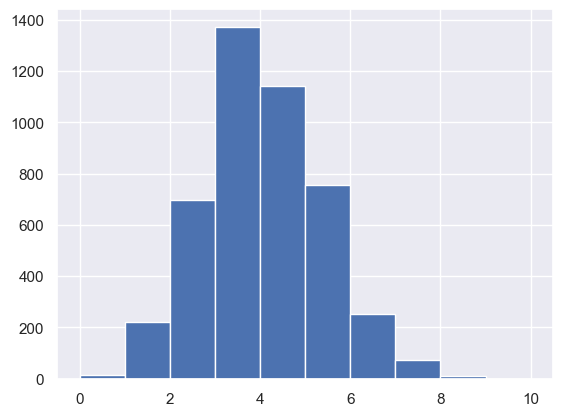

In [301]:
data = (df[cat_features]==0).sum(axis=1)
print(data.describe())
plt.hist(data, bins=range(11))
plt.show()

count    958.000000
mean       2.066806
std        1.073926
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        4.000000
dtype: float64


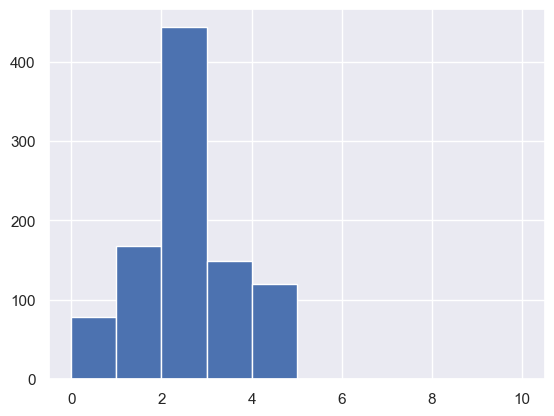

In [302]:
data = (df2[cat_features]==0).sum(axis=1)
print(data.describe())
plt.hist(data, bins=range(11))
plt.show()

### Concat 

In [303]:
concatenated_df = pd.concat([df, df2], axis=0, ignore_index=True)

In [304]:
concatenated_df = concatenated_df.drop_duplicates(keep='first')

Olhando o novo dataset, com uma distribuição melhor

count    5478.000000
mean        5.687295
std         1.406273
min         0.000000
25%         5.000000
50%         6.000000
75%         7.000000
max         9.000000
dtype: float64


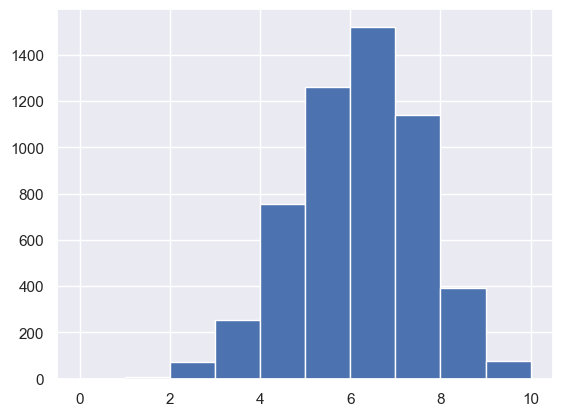

In [305]:
data = (concatenated_df[cat_features]!=0).sum(axis=1)
print(data.describe())
plt.hist(data, bins=range(11))
plt.show()

In [306]:
for c in concatenated_df.columns:
    if concatenated_df[c].dtype == 'int32':
        concatenated_df[c] = concatenated_df[c].astype("category")

In [307]:
concatenated_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5478 entries, 0 to 5477
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Top-left-square       5478 non-null   category
 1   Top-middle-square     5478 non-null   category
 2   Top-right-square      5478 non-null   category
 3   Middle-left-square    5478 non-null   category
 4   Middle-middle-square  5478 non-null   category
 5   Middle-right-square   5478 non-null   category
 6   Bottom-left-square    5478 non-null   category
 7   Bottom-middle-square  5478 non-null   category
 8   Bottom-right-square   5478 non-null   category
 9   Score                 5478 non-null   category
dtypes: category(10)
memory usage: 97.3 KB


In [308]:
#concatenated_df.to_pickle(f"{ROOT}/data/data_3.pkl")